In [36]:
import sys
sys.path.insert(1, '/scratch/gpfs/ls1546/icl_experiments/')

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import embedding
import transformer
import dataset_utils
from tqdm.auto import tqdm

In [38]:
#load MNIST
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
test_data = datasets.MNIST('../data', train=False,
                    transform=transform)

In [88]:
#augment MNIST with multiple tasks
n_tasks = 4
# task_gen = dataset_utils.RandomTasks(train_data, num_tasks=n_tasks)

# these will be the num of seeds we send into get_transformed_batch

In [89]:
batch_size = 32
lr = 3e-4
momentum = 0.9
steps = 2000
seq_len = 50 #this is what we previously called "batch_size"
trainloader = torch.utils.data.DataLoader(train_data, batch_size=seq_len, shuffle=True)
total_steps = int(np.ceil(steps/len(trainloader)))*len(trainloader)
log_freq = 100
device = 'cuda'
total_steps

2400

In [39]:
batch_size = 128
steps = 37_000
seq_len = 100 #this is what we previously called "batch_size"
trainloader = torch.utils.data.DataLoader(train_data, batch_size=seq_len, shuffle=True)
total_steps = int(np.ceil(steps/len(trainloader)))*len(trainloader)
epochs = int(np.ceil(total_steps/len(trainloader)))
len(trainloader), total_steps, epochs

(600, 37200, 62)

In [9]:
model = torch.load("icl_model.pth")
criterion = torch.nn.CrossEntropyLoss()
n_tasks = 2**18

def test_model(model, test_data, n_tasks, batch_size, seq_len, device='cuda'):
    correct = 0
    model.eval()
    
    test_task_list = []
    testloader = torch.utils.data.DataLoader(test_data, batch_size=seq_len, shuffle=False)
    num_batch = len(testloader)

    for images, labels in tqdm(testloader):
        # add batch dimension
        images = torch.unsqueeze(images, 0).to(device)
        labels = torch.unsqueeze(labels, 0).to(device)
        temp_images, temp_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
        test_task_list.append(curr_seed)
        for batch in range(batch_size):
            temp2_images, temp2_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
            temp_images = torch.cat((temp_images, temp2_images), 0)
            temp_labels = torch.cat((temp_labels, temp2_labels), 0)
            test_task_list.append(curr_seed)

        images = temp_images
        labels = temp_labels
        del temp_images, temp_labels, temp2_images, temp2_labels

        outputs = model((images,labels))
        pred = outputs[:,-1,:]
        loss = criterion(pred,labels[:,-1])
        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels[:,-1]).sum()
    accuracy = 100 * (correct.item()) / (batch_size*num_batch)
    print(correct.item())
    print(accuracy)

test_model(model, test_data, n_tasks, batch_size, seq_len, device='cuda')


  0%|                                                                                                                                         | 0/100 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.41 GiB. GPU 0 has a total capacity of 39.56 GiB of which 823.00 MiB is free. Process 1250838 has 584.00 MiB memory in use. Process 1787102 has 592.00 MiB memory in use. Process 1941582 has 584.00 MiB memory in use. Process 2657312 has 416.00 MiB memory in use. Process 4083712 has 416.00 MiB memory in use. Process 4180351 has 416.00 MiB memory in use. Process 1370793 has 1.07 GiB memory in use. Process 1417478 has 680.00 MiB memory in use. Including non-PyTorch memory, this process has 34.04 GiB memory in use. Of the allocated memory 31.41 GiB is allocated by PyTorch, and 2.14 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [80]:
#instantiate model
model = transformer.ImageICLTransformer(d_model=64,device='cuda',block_size=100)
print(model)

using flash attention
Embedding Transformer with 816332 parameters, 210360 parameters in embedder & 604682 parameters in transformer


In [81]:
#train the model to do MNIST classification

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50])

loss_history = [0]*total_steps
model.train()
data_avg_t = 0
loss_avg_t = 0

# here, our "batch_size" is actually the sequence length since we want to draw seq_length samples from the dataset, and then transform them batch_num times, where each transformation is a different task
# the batch should have shape: (batch_size,seq_len,1,28,28),
# right now it has shape: (seq_len,1,28,28), and we will add in the batch dimension in the loop below
step = 0
task_list = []
for epoch in tqdm(range(int(np.ceil(total_steps/len(trainloader))))):
    for images, labels in tqdm(trainloader):
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        # images, labels = task_gen.get_batch(batch_size,seq_len=seq_len,device=device)
        
        # add batch dimension
        images = torch.unsqueeze(images, 0).to(device)
        labels = torch.unsqueeze(labels, 0).to(device)
        # transform a batch, using a randomly selected task num from our list of n_tasks for each sequence in the batch, concatenated along the batch dimension
        for i in range(batch_size):
            if i == 0:
                temp_images, temp_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
            else:
                temp2_images, temp2_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
                temp_images = torch.cat((temp_images, temp2_images), 0)
                temp_labels = torch.cat((temp_labels, temp2_labels), 0)
            task_list.append(curr_seed)
        end.record()
        torch.cuda.synchronize()
        data_avg_t += start.elapsed_time(end)
        images = temp_images
        labels = temp_labels
        del temp_images, temp_labels, temp2_images, temp2_labels

        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        start.record()
        optimizer.zero_grad()
        outputs = model((images,labels))
        pred = outputs[:,-1,:]
        loss = criterion(pred,labels[:,-1])
        loss.backward()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        loss_avg_t += start.elapsed_time(end)
        loss_history[step] = loss.item()
        step += 1

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]


DATA:  107.71286429405212
LOSS:  221.5931656519572


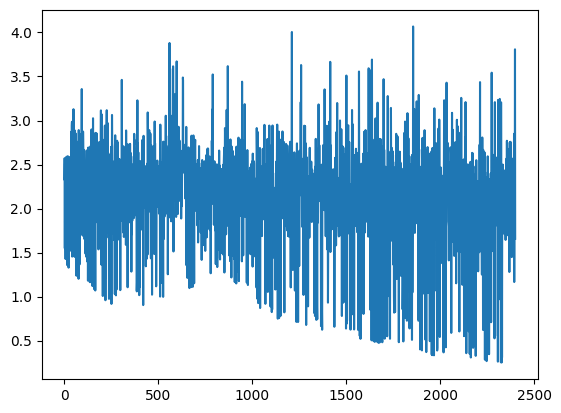

In [82]:
loss_history = np.array(loss_history)[:step]
plt.plot(loss_history)
print("\nDATA: ", data_avg_t/total_steps)
print("LOSS: ", loss_avg_t/total_steps)

In [83]:
def test_model(model, test_data, n_tasks, batch_size=32, seq_len=50, device='cuda'):
    correct = 0
    model.eval()
    
    test_task_list = []
    testloader = torch.utils.data.DataLoader(test_data, batch_size=seq_len, shuffle=False)
    num_batch = len(testloader)

    for images, labels in tqdm(testloader):
        # add batch dimension
        images = torch.unsqueeze(images, 0).to(device)
        labels = torch.unsqueeze(labels, 0).to(device)
        for batch in range(batch_size):
            if batch == 0:
                temp_images, temp_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
            else:
                temp2_images, temp2_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
                temp_images = torch.cat((temp_images, temp2_images), 0)
                temp_labels = torch.cat((temp_labels, temp2_labels), 0)
            test_task_list.append(curr_seed)

        images = temp_images
        labels = temp_labels
        del temp_images, temp_labels, temp2_images, temp2_labels

        outputs = model((images,labels))
        pred = outputs[:,-1,:]
        loss = criterion(pred,labels[:,-1])
        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels[:,-1]).sum()
    accuracy = 100 * (correct.item()) / (batch_size*num_batch)
    print(correct.item())
    print(accuracy)

In [84]:
test_model(model, test_data, n_tasks, batch_size=32, seq_len=seq_len, device='cuda')

  0%|          | 0/200 [00:00<?, ?it/s]

1104
17.25


In [4]:
loss_history = np.load('loss_history.npy')

Text(0.5, 0, 'batch number')

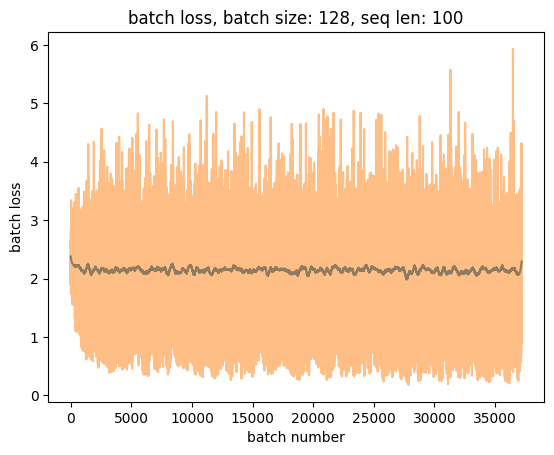

In [30]:
from scipy.signal import savgol_filter
plt.plot(savgol_filter(loss_history, 500, 3))
plt.plot(loss_history, alpha=.5)
plt.title(f'batch loss, batch size: {128}, seq len: {100}')
plt.ylabel('batch loss')
plt.xlabel('batch number')

In [41]:
40000/67*53

31641.79104477612

In [42]:
.2896*8

2.3168